# Task 1: Implementing the Noisy XOR Problem in PyTorch



## Data Generation Class





In [1]:
from torch.utils.data import Dataset
import numpy as np

class NoisyXORDataset(Dataset):
    def __init__(self, num_samples=1000, s=0.1):
        self.num_samples = num_samples
        self.s = s
        self.data = []
        self.labels = []
        self.generate_data()
        
    def generate_data(self):
        m = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
        for _ in range(self.num_samples):
            idx = np.random.choice(4)
            m1, m2 = m[idx]
            eta = np.random.randn(2)
            x1 = m1 + self.s * eta[0]
            x2 = m2 + self.s * eta[1]
            y = m1 ^ m2
            self.data.append([x1, x2])
            self.labels.append(y)
        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


## Model Class



In [2]:
import torch.nn as nn

class FeedForwardNet(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[3], output_size=1):
        super(FeedForwardNet, self).__init__()
        layers = []
        in_features = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.Tanh())
            in_features = hidden_size
        layers.append(nn.Linear(in_features, output_size))
        layers.append(nn.Identity())
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


## Training Loop



In [3]:
import torch
from torch.utils.data import DataLoader

# Create dataset and data loader
dataset = NoisyXORDataset(num_samples=1000, s=0.1)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model = FeedForwardNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


## Visualisation

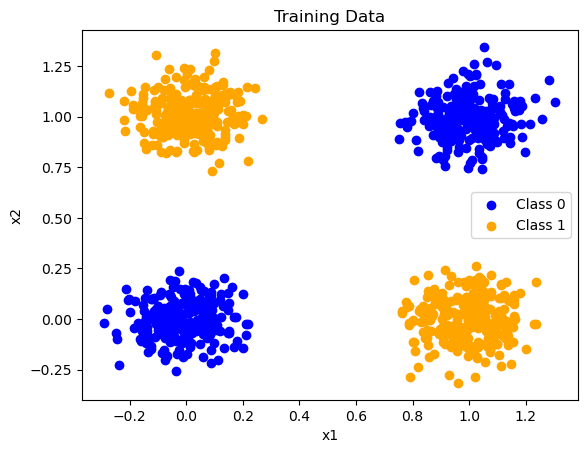

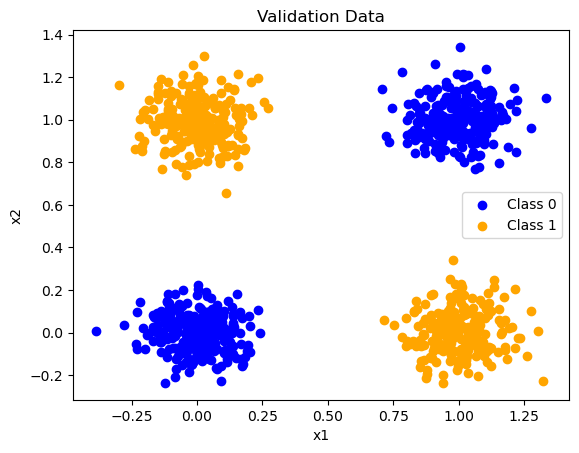

In [5]:
import matplotlib.pyplot as plt

# Generate validation data
val_dataset = NoisyXORDataset(num_samples=1000, s=0.1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Function to plot data
def plot_data(dataset, title):
    data = dataset.data.numpy()
    labels = dataset.labels.numpy().flatten()
    plt.scatter(data[labels==0, 0], data[labels==0, 1], color='blue', label='Class 0')
    plt.scatter(data[labels==1, 0], data[labels==1, 1], color='orange', label='Class 1')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()

# Plot training data
plot_data(dataset, 'Training Data')

# Plot validation data
plot_data(val_dataset, 'Validation Data')


### a)

In PyTorch, there are two binary cross entropy loss functions:

- nn.BCELoss(): This loss function expects the output of the model to be passed through a sigmoid activation function, producing probabilities between 0 and 1.

- nn.BCEWithLogitsLoss(): This loss function combines a sigmoid layer and the binary cross entropy loss in one single class. It is more numerically stable than using a plain sigmoid followed by a BCELoss().

We opted in using nn.BCEWithLogitsLoss() because it is said to be more stable and efficient. It handles the numerical issues that can arise when using sigmoid and BCELoss() separately.

# Task 2: Testing Different Network Configurations



In [4]:
import itertools

depths = range(0, 4)
widths = range(1, 4)
results = {}

for depth, width in itertools.product(depths, widths):
    losses = []
    for _ in range(5):  # Repeat multiple times for averaging
        # Create model with specified depth and width
        hidden_sizes = [width] * depth
        model = FeedForwardNet(hidden_sizes=hidden_sizes)
        
        # Loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        # Training loop
        num_epochs = 20
        for epoch in range(num_epochs):
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Evaluate on new data
        test_dataset = NoisyXORDataset(num_samples=1000, s=0.1)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        total_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
        average_loss = total_loss / len(test_loader)
        losses.append(average_loss)
    
    mean_loss = np.mean(losses)
    std_loss = np.std(losses)
    results[(depth, width)] = (mean_loss, std_loss)
    print(f'Depth: {depth}, Width: {width}, Mean Loss: {mean_loss:.4f}, Std Loss: {std_loss:.4f}')


Depth: 0, Width: 1, Mean Loss: 0.6931, Std Loss: 0.0014
Depth: 0, Width: 2, Mean Loss: 0.6938, Std Loss: 0.0010
Depth: 0, Width: 3, Mean Loss: 0.6935, Std Loss: 0.0015
Depth: 1, Width: 1, Mean Loss: 0.5151, Std Loss: 0.0232
Depth: 1, Width: 2, Mean Loss: 0.3064, Std Loss: 0.1232
Depth: 1, Width: 3, Mean Loss: 0.0471, Std Loss: 0.0131
Depth: 2, Width: 1, Mean Loss: 0.4855, Std Loss: 0.0117
Depth: 2, Width: 2, Mean Loss: 0.0883, Std Loss: 0.1350
Depth: 2, Width: 3, Mean Loss: 0.0112, Std Loss: 0.0102
Depth: 3, Width: 1, Mean Loss: 0.4899, Std Loss: 0.0134
Depth: 3, Width: 2, Mean Loss: 0.0785, Std Loss: 0.1266
Depth: 3, Width: 3, Mean Loss: 0.1066, Std Loss: 0.1946
